# TP Intelligence Bio-Inspiré - Réseaux de neurones (Exo 1)

## M2 IA Lyon 1 - Alexis Pister et Raphael Teitgen

L’objectif de ce TP est d’implémenter un réseau de neurone pour résoudre le problème de classification du jeu de données MNIST constitué d'images représentant des chiffres de 0 à 9. Le but est d'entrainer le modèle avec un jeu d'apprentissage puis de le tester avec un jeu de test, afin de déterminer le chiffre representé par l'image sans avoir accès au label. Nous allons commencé par implémenter un modèle simple que nous allons améliorer jusqu'à créer un perceptron multi-couches.

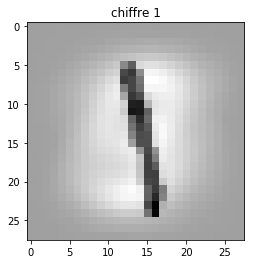

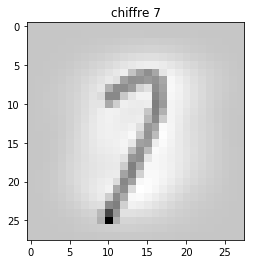

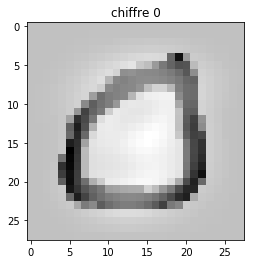

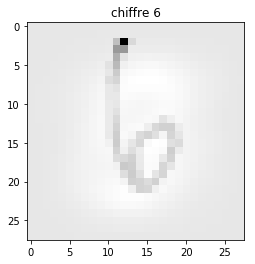

In [78]:
# Imports et code pour decompresser les donnees 
# (ecrit par Mathieu Lefort)
import gzip # pour décompresser les données
import pickle # pour désérialiser les données
import numpy # pour pouvoir utiliser des matrices
import matplotlib.pyplot as plt # pour l'affichage
import torch,torch.utils.data


# fonction qui va afficher l'image située à l'index index
def affichage(image,label):
    # on récupère à quel chiffre cela correspond (position du 1 dans label)
    label = numpy.argmax(label)
    # on crée une figure
    plt.figure()
    # affichage du chiffre
    # le paramètre interpolation='nearest' force python à afficher chaque valeur de la matrice sans l'interpoler avec ses voisines
    # le paramètre cmap définit l'échelle de couleur utilisée (ici noire et blanc)
    plt.imshow(image,interpolation='nearest',cmap='binary')
    # on met un titre
    plt.title('chiffre '+str(label))
    # on affichage les figures créées
    plt.show()
    

# nombre d'image lues à chaque fois dans la base d'apprentissage (laisser à 1 sauf pour la question optionnelle sur les minibatchs)
TRAIN_BATCH_SIZE = 1
# on charge les données de la base MNIST
data = pickle.load(gzip.open('mnist_light_CN.pkl.gz'),encoding='latin1')
# images de la base d'apprentissage
train_data = torch.Tensor(data[0][0])
# labels de la base d'apprentissage
train_data_label = torch.Tensor(data[0][1])
# images de la base de test
test_data = torch.Tensor(data[1][0])
# labels de la base de test
test_data_label = torch.Tensor(data[1][1])
# on crée la base de données d'apprentissage (pour torch)
train_dataset = torch.utils.data.TensorDataset(train_data,train_data_label)
# on crée la base de données de test (pour torch)
test_dataset = torch.utils.data.TensorDataset(test_data,test_data_label)
# on crée le lecteur de la base de données d'apprentissage (pour torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
# on crée le lecteur de la base de données de test (pour torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


# Affichages
# 10 fois
# for i in range(0,10):
#     # on demande les prochaines données de la base
#     (_,(image,label)) = enumerate(train_loader).next()
#     # on les affiche
#     affichage(image[0,:].numpy(),label[0,:].numpy())


# NB pour lire (plus proprement) toute la base (ce que vous devrez faire dans le TP) plutôt utiliser la formulation suivante
# Affichage de 4 images
i = 0
for image,label in train_loader:
    if i < 4:
        affichage(image[0,:].numpy(),label[0,:].numpy())
        i += 1


## Partie 1 : Le perceptron

Nous allons commencer par coder l'algorithme du Perceptron. Le jeu de données ayant 10 labels, le model comprendra donc une couche de sortie de 10 neurones (chaque neurone correspond à un label). Chaque neurone sera connecté aux 784 entrées correspondant aux pixels de l'image par une matrice de poids.

In [79]:
%%time
#Parametres
N_entree = 785
N_neurones = 10
eta = 0.001
N_apprentissage = 300 #Nb d'image utilisées pour l'apprentissage


#Matrice des poids, lignes (i) : neurones, colonnes (j) : entrees
#On initialise tous les poids à 0.01
W = torch.ones(10, 785, dtype=torch.double) * 0.01
W[:, 0] = 0.01 #Biais

# Entrainement
for i, (image, label) in enumerate(train_loader):
    if i < N_apprentissage:
        #print(i)
        #Tensor representant l'image d'entree
        entree = image
        #On 'aplatit' le tableau
        entree = entree.flatten()
        #On ajoute le biais au debut de l'entree
        entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree)) 
        
        #Calcul de la sortie des neurones
        Y = torch.mv(W, entree)        
        
        #Erreur
        Err = label.flatten().double() - Y
        #print(Err[i])
        
        #Mise a jour des poids
        for i in range(len(W)):
            for j in range(len(W[0])):
                W[i,j] = W[i,j] + eta * entree[j] * Err[i]
                
        #print(Y)
        

CPU times: user 2min 6s, sys: 3.77 s, total: 2min 10s
Wall time: 1min 11s


In [80]:
# On utilise notre reseau sur le jeu de test

#Nb d'images et compteur de positifs
Nb_positif = 0
Nb_images = len(test_loader.batch_sampler)

# Test
for i, (image, label) in enumerate(test_loader):
    #print(i)
    entree = image
    entree = entree.flatten()
    #On ajoute le biais au debut de l'entree
    entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree)) 
    
    #Calcul de la sortie des neurones
    Y = torch.mv(W, entree)
    #print(Y)
    #print(label)
    
    result_label = np.argmax(Y, axis=0)
    true_label = np.argmax(label.flatten(), axis=0)
    
    if result_label == true_label:
        Nb_positif += 1
        
        
print("La fréquence de bonne classification est de : ", Nb_positif / Nb_images)

La fréquence de bonne classification est de :  0.7128571428571429


Avec une valeur de $\eta$ de 0.001, une initialisation des poids uniforme à 0.01 et pour un jeu d'apprentissage comprenant 300 images nous obtenons un résultats d'environ 70% ce qui est plutot bon (75% obtenu au mieux sur quelques essais). Ajouter plus d'images semblent être inutiles : nous avons essayé avec 500 images mais cela n'améliore pas la classification (73% de bon résultat pour un essai).

Nous avons remarqué que prendre un $\eta$ trop grand faisait vite exploser les valeurs des poids et des sorties des neurones. Avec un $\eta$ de 0.01 les valeurs explosait ayant pour conséquence un scrore moins bon d'environ 50%. Avec un pas d'apprentissage trop grand, il semble donc que le modèle n'arrive pas bien à converger vers un bon minimum local et diverge sur des valeurs des paramètres de plus en plus grands.

Nous avons ensuite fait varier l'initialisation des poids à 0.1 puis 1 mais cela ne semble pas affecter le résultat. Cela est logique : Ce sont plus leurs valeurs relatives qui influencent le modèle que leurs valeurs propres.

In [160]:
# Partie 3 : Deep network

#PB DU BIAIS : il ne doit pas etre autant connecté que les autres neurones
class Deep_network:
    def __init__(self, train_loader, test_loader, nbCouches, nbLabels, taille_entree, tailles_couches):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.nbCouches = nbCouches
        self.nbLabels = nbLabels
        self.taille_entree = taille_entree #Taille de l'entree
        
        #Liste contenant les tailles de chaque couches
        #(on rajoute un element a chaque couche sauf la derniere pour les biais)
        self.tailles_couches = [self.taille_entree] + tailles_couches
        for i in range(len(self.tailles_couches)-1):
            self.tailles_couches[i] += 1
        
        print(self.tailles_couches)
        
        #liste ou chaque element correspond à une matrice des poids d'une couche
        self.W = []
        for i in range(len(self.tailles_couches[:-1])):
            # Matrice des poids entre les couches i et i+1
            w = torch.ones(self.tailles_couches[i+1], self.tailles_couches[i],
                           dtype=torch.double) * 0.01
            #On rajoute les biais
            w[:, 0] = 0.01
            w.requires_grad_(True)
            self.W.append(w)
        
            
    # Train the model from train_set
    def training(self, eta = 0.001, nbImages = 200):
        for i, (image, label) in enumerate(self.train_loader):
            if i < nbImages:
                #print(i)
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))
                
                #Liste ou chaque element correspond à un tensor contenant les sorties de chaque couche
                Y = [entree]

                #Calcul de la sortie des neurones
                for i, W in enumerate(self.W):
                    if i == len(self.W) - 1:
                        # Pour calculer la couche de sortie (fonction lineaire)
                        y = torch.mv(W, Y[i])
                    else:
                        # Pour calculer les autres couches (fonction sigmoide)
                        y = (1 / (1 + torch.exp(-torch.mv(W, Y[i]))))
                        
                    Y.append(y)
                
                #print(Y)
                
                
                # Fonction de cout (sum square error)
                Err = (label.flatten().double() - Y[-1]).pow(2).sum() * 0.5
                # Back propagation of error
                Err.backward()
                
                #Mise a jour des poids
                for i in range(len(self.W)):
                    with torch.no_grad():
                        self.W[i] += eta * self.W[i].grad
                        # On remet les gradients a 0
                        self.W[i].grad.data.zero_()
                        
                #print(Y[-1])
           
    # Test the model with test set
    def run(self):
        Nb_positif = 0
        Nb_images = len(test_loader.batch_sampler)
        for i, (image, label) in enumerate(self.test_loader):
            #print(i)
            entree = image
            entree = entree.flatten()
            #On ajoute le biais au debut de l'entree
            entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree)) 

            #Calcul de la sortie des neurones
            Y = [entree]
            for i, W in enumerate(self.W):
                if i == len(self.W) - 1:
                    # Pour calculer la couche de sortie (fonction lineaire)
                    y = torch.mv(W, Y[i])
                else:
                    # Pour calculer les autres couches (fonction sigmoide)
                    y = (1 / (1 + torch.exp(-torch.mv(W, Y[i]))))

                Y.append(y)
            
            result_label = np.argmax(Y[-1].detach(), axis=0)
            true_label = np.argmax(label.flatten(), axis=0)

            if result_label == true_label:
                Nb_positif += 1
                
        #Renvoie le score    
        return(Nb_positif / Nb_images)
                    

        
        
Dn = Deep_network(train_loader, test_loader, nbCouches = 3, nbLabels = 10,
                  taille_entree = 784, tailles_couches = [100, 30, 10])

# Training of the network
Dn.training(nbImages = 400)
print(Dn.run())



[785, 101, 31, 10]
0.11


In [ ]:
#Q2 Shallow network (une couche cachée)

#Matrice des poids, lignes (i) : neurones, colonnes (j) : entrees
#W = torch.rand(10, 785)
W = torch.ones(10, 785, dtype=torch.double) * 0.01
W[:, 0] = 0.01 #Biais

W = torch.ones(10, 10, dtype=torch.double) * 0.01

# Entrainement
for i, (image, label) in enumerate(train_loader):
        print(i)
        #Tensor representant l'image d'entree
        entree = image
        #On 'aplatit' le tableau
        entree = entree.flatten()
        #On ajoute le biais au debut de l'entree
        entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree)) 
        
        #Calcul de la sortie de la couche cachée
        Y = torch.mv(W, entree)
        Y = 1 / (1 + exp(-Y))
        
        #Calcul de la sortie de la couche finale
        Y2 = torch.mv(W2, Y)
        
        #Erreur de la couche de sortie
        Err = abel.flatten().double() - Y
        
        #Erreur de la couche cachee
        
        
        #Mise a jour des poids
        for i in range(len(W)):
            for j in range(len(W[0])):
                W[i,j] = W[i,j] + eta * entree[j] * Err[i]
                
        print(Y)



In [129]:
#TESTS
W = []
for i in range(3):
    w = torch.ones(2, 3) * 2
    w.requires_grad_(True)
    print(w)
    W.append(w)
    
for i in W:
    print(i)


tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)
